<a href="https://colab.research.google.com/github/RandivCosta/data-analysis/blob/main/Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analysis with standard water quality guidelines

###Blue flag, US EPA and WHO guidelines

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gmean
import os

In [ ]:
data = pd.read_csv('adjusted_data.csv')
data.columns = data.columns.str.replace(r'[\(\)\- ]', '_', regex=True).str.lower()

# rename columns
column_rename = {
    'bc_enterococcus__cfu/100ml_': 'enterococcus',
    'bc_fecal_coliform_cfu/100ml_': 'fecal_coliform',
    'bc_e_coli__cfu/100ml_': 'e_coli',
    'pp_ph': 'ph',
    'pp_conductivity': 'conductivity',
    'pp_salinity': 'salinity',
    'pp_temperature': 'temperature',
    'ep_rainfall': 'rainfall',
    'ep_wind_speed': 'wind_speed'
}
data = data.rename(columns=column_rename)

# filter for seawater
sea_water = data[data['area'] == 'Sea Water'].copy()

# find the weekly mean
sea_water = sea_water.loc[:, ~sea_water.columns.isin(['site','area'])]
sea_water['week'] = pd.factorize(sea_water['week'])[0] + 1
sea_water = sea_water.groupby('week', as_index=False).mean()
# print(sea_water)

# visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]


# extract bacterial counts
bacteria_columns = ['enterococcus','fecal_coliform','e_coli']

### calculate key statistics for each bacterium

In [ ]:
def calculate_percentiles(df):
    results = {}
    for bacterium in bacteria_columns:
        # handle zeros by replacing with 1 (as per EU Bathing Water Directive)
        values = df[bacterium].replace(0, 1)
        log_values = np.log10(values)
        # print(values,log_values)

        results[bacterium] = {
            'geometric_mean': gmean(values),
            '95_percentile': 10**(log_values.mean() + 1.65 * log_values.std()),
            '75_percentile': values.quantile(0.75),
            'max_value': values.max(),
            'n_samples': len(values)
        }
    return pd.DataFrame(results).T

bacteria_stats = calculate_percentiles(sea_water)
print(bacteria_stats.round(2))

                geometric_mean  95_percentile  75_percentile  max_value  \
enterococcus           4520.75       11920.84        6258.33    8666.67   
fecal_coliform         5942.58       13992.68        7991.67   11416.67   
e_coli                 3696.79       11115.26        5458.33    7666.67   

                n_samples  
enterococcus         10.0  
fecal_coliform       10.0  
e_coli               10.0  


### Evaluate against standards

In [ ]:
def evaluate_standards(stats_df):
    evaluation = {}

    # Blue Flag Criteria
    blue_flag = {
        'e_coli': {'limit': 250, 'passed': stats_df.loc['e_coli', '95_percentile'] <= 250},
        'enterococcus': {'limit': 100, 'passed': stats_df.loc['enterococcus', '95_percentile'] <= 100}
    }

    # US EPA Guidelines
    us_epa = {
        'geometric_mean': {'limit': 35, 'value': stats_df.loc['enterococcus', 'geometric_mean']},
        'stat_threshold': {'limit': 130, 'value': stats_df.loc['enterococcus', '95_percentile']}
    }

    # WHO Classification
    who_value = stats_df.loc['enterococcus', 'geometric_mean']
    if who_value <= 40:
        who_class = 'A'
    elif 40 < who_value <= 200:
        who_class = 'B'
    elif 200 < who_value <= 500:
        who_class = 'C'
    else:
        who_class = 'D'

    evaluation['blue_flag'] = blue_flag
    evaluation['us_epa'] = us_epa
    evaluation['who'] = {'class': who_class, 'value': who_value}

    return evaluation

standards_evaluation = evaluate_standards(bacteria_stats)
print(standards_evaluation)

{'blue_flag': {'e_coli': {'limit': 250, 'passed': np.False_}, 'enterococcus': {'limit': 100, 'passed': np.False_}}, 'us_epa': {'geometric_mean': {'limit': 35, 'value': np.float64(4520.747253820526)}, 'stat_threshold': {'limit': 130, 'value': np.float64(11920.841152436351)}}, 'who': {'class': 'D', 'value': np.float64(4520.747253820526)}}


#### Visualization

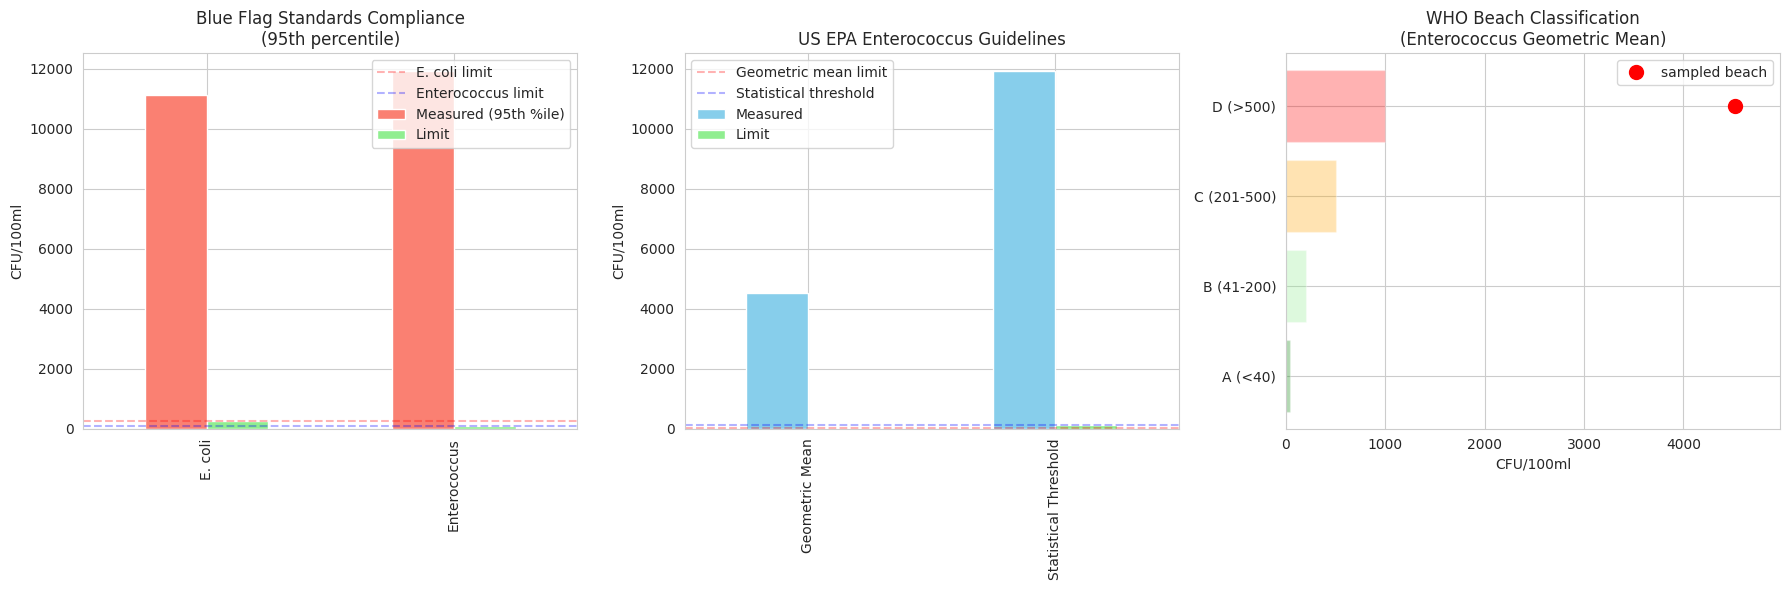

In [ ]:
def plot_bacterial_compliance(stats_df, evaluation):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Blue Flag Compliance
    blue_flag_data = {
        'E. coli': [stats_df.loc['e_coli', '95_percentile'], 250],
        'Enterococcus': [stats_df.loc['enterococcus', '95_percentile'], 100]
    }
    pd.DataFrame(blue_flag_data, index=['Measured (95th %ile)', 'Limit']).T.plot(
        kind='bar', ax=axes[0], color=['salmon', 'lightgreen'])
    axes[0].set_title('Blue Flag Standards Compliance\n(95th percentile)')
    axes[0].set_ylabel('CFU/100ml')
    axes[0].axhline(250, color='red', linestyle='--', alpha=0.3, label='E. coli limit')
    axes[0].axhline(100, color='blue', linestyle='--', alpha=0.3, label='Enterococcus limit')
    axes[0].legend()

    # US EPA Compliance
    us_epa_data = {
        'Geometric Mean': [stats_df.loc['enterococcus', 'geometric_mean'], 35],
        'Statistical Threshold': [stats_df.loc['enterococcus', '95_percentile'], 130]
    }
    pd.DataFrame(us_epa_data, index=['Measured', 'Limit']).T.plot(
        kind='bar', ax=axes[1], color=['skyblue', 'lightgreen'])
    axes[1].set_title('US EPA Enterococcus Guidelines')
    axes[1].set_ylabel('CFU/100ml')
    axes[1].axhline(35, color='red', linestyle='--', alpha=0.3, label='Geometric mean limit')
    axes[1].axhline(130, color='blue', linestyle='--', alpha=0.3, label='Statistical threshold')
    axes[1].legend()

    # WHO Classification - Fixed to handle Class D
    who_classes = ['A (<40)', 'B (41-200)', 'C (201-500)', 'D (>500)']
    who_values = [40, 200, 500, 1000]  # Extended scale for Class D
    who_colors = ['green', 'lightgreen', 'orange', 'red']

    # Get class index safely
    class_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
    class_idx = class_mapping[evaluation['who']['class']]

    axes[2].barh(who_classes, who_values, color=who_colors, alpha=0.3)
    axes[2].plot(evaluation['who']['value'],
                class_idx,
                'ro', markersize=10, label='sampled beach')
    axes[2].set_title('WHO Beach Classification\n(Enterococcus Geometric Mean)')
    axes[2].set_xlabel('CFU/100ml')
    axes[2].set_xlim(0, max(1000, evaluation['who']['value'] * 1.1))  # dynamic scaling
    axes[2].legend()

    plt.tight_layout()
    # plt.savefig('water_quality_compliance.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_bacterial_compliance(bacteria_stats, standards_evaluation)

### Evaluation results

In [ ]:
print("\n=== Water Quality Standards Evaluation ===")
print("\nBlue Flag Criteria:")
print(f"E. coli 95th percentile: {bacteria_stats.loc['e_coli', '95_percentile']:.1f} CFU/100ml (Limit: 250)")
print(f"Enterococcus 95th percentile: {bacteria_stats.loc['enterococcus', '95_percentile']:.1f} CFU/100ml (Limit: 100)")

print("\nUS EPA Guidelines:")
print(f"Enterococcus geometric mean: {bacteria_stats.loc['enterococcus', 'geometric_mean']:.1f} CFU/100ml (Limit: 35)")
print(f"Enterococcus statistical threshold (95th %ile): {bacteria_stats.loc['enterococcus', '95_percentile']:.1f} CFU/100ml (Limit: 130)")

print("\nWHO Beach Classification:")
print(f"Geometric mean: {bacteria_stats.loc['enterococcus', 'geometric_mean']:.1f} CFU/100ml")
print(f"Classification: {standards_evaluation['who']['class']}")


=== Water Quality Standards Evaluation ===

Blue Flag Criteria:
E. coli 95th percentile: 11115.3 CFU/100ml (Limit: 250)
Enterococcus 95th percentile: 11920.8 CFU/100ml (Limit: 100)

US EPA Guidelines:
Enterococcus geometric mean: 4520.7 CFU/100ml (Limit: 35)
Enterococcus statistical threshold (95th %ile): 11920.8 CFU/100ml (Limit: 130)

WHO Beach Classification:
Geometric mean: 4520.7 CFU/100ml
Classification: D
